<a href="https://www.kaggle.com/code/macmyller/pdi-project?scriptVersionId=202321305" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Imports

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

# Utils

In [2]:
# Setting up file paths
train_path = '/kaggle/input/kermany2018/OCT2017 /train'
test_path = '/kaggle/input/kermany2018/OCT2017 /test'
val_path = '/kaggle/input/kermany2018/OCT2017 /val'

In [3]:
categories = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
num_classes = len(categories) 
image_size = (128, 128)
# image_size = (128, 128, 3)
batch_size = 84

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Exploratory Analysis

In [4]:
# EDA: Count number of images per category in each set
def count_images_in_directory(directory):
    category_count = {}
    for category in categories:
        category_path = os.path.join(directory, category)
        category_count[category] = len(os.listdir(category_path))
    return category_count


train_distribution, test_distribution, val_distribution = \
count_images_in_directory(train_path), count_images_in_directory(test_path), count_images_in_directory(val_path)

In [5]:
df_distribution = pd.DataFrame({
    "Train":train_distribution, 
    "Test":test_distribution, 
    "Validation":val_distribution
})

df_distribution.loc["Total"] = df_distribution.sum(axis=0)
df_distribution["Total"] = df_distribution.sum(axis=1)

df_distribution

,Train,Test,Validation,Total
CNV,37205,242,8,37455
DME,11348,242,8,11598
DRUSEN,8616,242,8,8866
NORMAL,26315,242,8,26565
Total,83484,968,32,84484


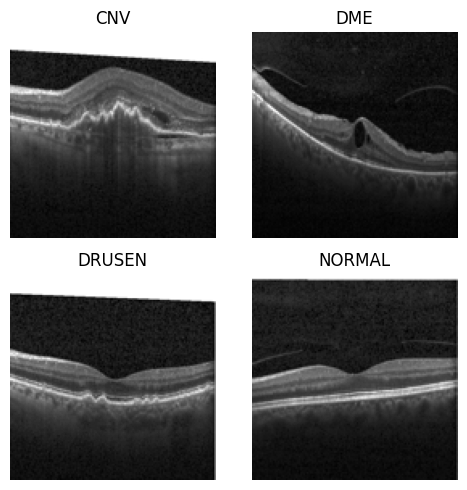

In [6]:
from PIL import Image

image_files = {
    'CNV': f'{val_path}/CNV/CNV-6294785-1.jpeg',
    'DME': f'{val_path}/DME/DME-9583225-1.jpeg',
    'DRUSEN': f'{val_path}/DRUSEN/DRUSEN-9800172-2.jpeg',
    'NORMAL': f'{val_path}/NORMAL/NORMAL-4872585-1.jpeg'
}

target_size = (128, 128)

images = {cls: Image.open(img_path).resize(target_size) for cls, img_path in image_files.items()}

fig, axes = plt.subplots(2, 2, figsize=(5, 5))

for ax, (cls, img) in zip(axes.flatten(), images.items()):
    ax.set_title(cls)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.tight_layout() 
plt.show()


# Load Data (torch)

In [7]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split

# TODO: MODIFICAR PARA USAR AS MESMAS TRANSFORMAÇÕES PRESENTES NO ARTIGO
# Transformações do dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Carregar o dataset
data_directory = train_path
%time dataset = datasets.ImageFolder(root=data_directory, transform=transform)

CPU times: user 1.5 s, sys: 2.7 s, total: 4.2 s
Wall time: 1min 42s


Reproduzir datasets com a mesma proporção do artigo (train: 90.16%, test: 8%, val: 1.84%) 

In [17]:
# import math 

# train_dataset, test_dataset, val_dataset = random_split(dataset, [0.9016, 0.08, 0.0184])

# batch_size = 84  # Tamanho do batch

# # Criar DataLoaders
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# TODO: UTILIZAR PEQUENAS PROPORCOES DOS DADOS PARA TREINAR/TESTAR/AVALIAR 
# OS MODELOS ENQUANTO NÃO RODAMOS DEFINITIVAMENTE

# TODO: LEMBRAR DE MODIFICAR PARA OS DATASETS COM PROPORÇÕES IGUAIS 
# AO DO ARTIGO QUANDO FOR RODAR DEIFINITIVAMENTE


Reproduzir datasets com a mesma distribuição entre as classes do artigo (consequentemente a mesma proporção)

In [42]:
import math
from torch.utils.data import DataLoader, random_split, Subset

labels = dataset.targets  # Acessa os rótulos
num_classes = len(dataset.classes)  # Número de classes

# Definindo as quantidades desejadas para cada dataset
desired_counts = { # classes 0, 1, 2, 3 / 'CNV', 'DME', 'DRUSEN', 'NORMAL'
    'train': [33509, 10197, 7753, 23811],  # Quantidades para treinamento
    'test':  [2951,    936, 693,   2098],  # Quantidades para teste
    'val':   [745,     215, 170,    406]   # Quantidades para validação
}

class_indices = {i: [] for i in range(num_classes)}  # Armazena os índices de cada classe

# Armazena índices para cada classe
for idx, label in enumerate(labels):
    class_indices[label].append(idx)

# Gera os índices desejados para a amostragem
train_indices, test_indices, val_indices = [], [], []

# Para cada classe, pega os índices desejados para train, test e val
for cls in range(num_classes):
    # Treinamento
    train_size = min(desired_counts['train'][cls], len(class_indices[cls]))
    train_indices.extend(class_indices[cls][:train_size])
    
    # Teste
    test_size = min(desired_counts['test'][cls], len(class_indices[cls]) - train_size)
    test_indices.extend(class_indices[cls][train_size:train_size + test_size])
    
    # Validação
    val_size = min(desired_counts['val'][cls], len(class_indices[cls]) - train_size - test_size)
    val_indices.extend(class_indices[cls][train_size + test_size:train_size + test_size + val_size])

Total Treinamento: 75270, Total Teste: 6678, Total Validação: 1536


In [59]:
train_dataset, test_dataset, val_dataset = \
Subset(dataset, train_indices), Subset(dataset, test_indices), Subset(dataset, val_indices)
len(train_dataset), len(test_dataset), len(val_dataset)

(75270, 6678, 1536)

In [114]:
# Cria DataLoaders
batch_size = 84  # Ajutar o tamanho de batch quando for propor melhorias em comparação ao artigo
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [112]:
from collections import Counter

print("Train distribution")
%time train_dataset_distribution = Counter(categories[label] for _, label in train_dataset)
print("Test distribution")
%time test_dataset_distribution = Counter(categories[label] for _, label in test_dataset)
print("Val distribution")
%time val_dataset_distribution = Counter(categories[label] for _, label in val_dataset)

Train distribution
CPU times: user 14min 6s, sys: 16.5 s, total: 14min 23s
Wall time: 8min 59s
Test distribution
CPU times: user 1min 15s, sys: 1.5 s, total: 1min 16s
Wall time: 47.3 s
Val distribution
CPU times: user 16.5 s, sys: 289 ms, total: 16.8 s
Wall time: 9.71 s


In [115]:
data = {
    'Training': train_dataset_distribution, 
    'Testing': test_dataset_distribution, 
    'Validation': val_dataset_distribution, 
}

df_distribution = pd.DataFrame(data)
df_distribution.loc["Total"] = df_distribution.sum()
df_distribution["Total"] = df_distribution.sum(axis=1)
df_distribution[["Total", "Training", "Testing", "Validation"]].T

,CNV,DME,DRUSEN,NORMAL,Total
Total,37205,11348,8616,26315,83484
Training,33509,10197,7753,23811,75270
Testing,2951,936,693,2098,6678
Validation,745,215,170,406,1536


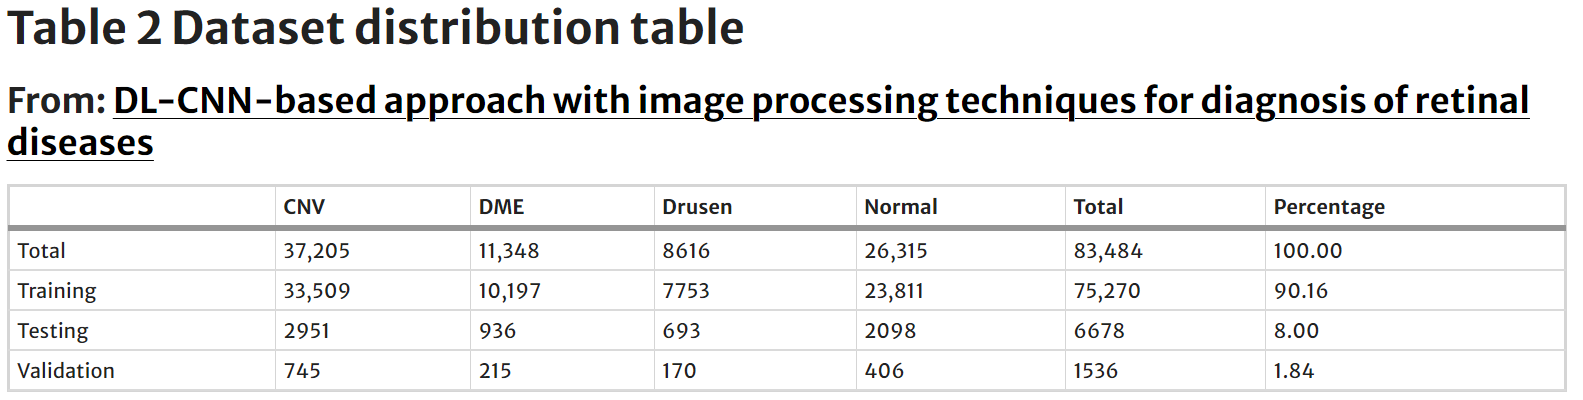

# Preprocessing

Etapas para pré-processamento de dados:

1.
Leia arquivos do diretório.

2.
Aplique o redimensionamento de cada imagem para 150 × 150 pixels.

3.
Aplique a operação CentreCrop com dimensões finais de 128 × 128 pixels a cada imagem.

4.
Converta a imagem para o tipo de dados tensor para compatibilidade com o modelo.

5.
Normalize a imagem subtraindo a média de cada valor de pixel e dividindo o resultado pelo desvio padrão usando a transformação padrão.



In [ ]:
# TODO: PREPROCESSAR AS IMAGENS

Etapas para aprimoramento de imagem:

1.
Leia arquivos do diretório.

2.
Aplique filtro de desfoque médio para suavizar.

3.
Converta para escala de cinza para operações futuras.

4.
Aplique CLAHE sobre a imagem para melhorar o contraste baixo.

5.
Limiar de imagem por limites de corte de limiar adequados.

6.
Remova ruídos e quebras adicionais na estrutura por meio de operação de morfologia.

7.
Extraia contornos da saída acima para extrair bordas da camada da retina (as outras técnicas de detecção de bordas não foram úteis, conforme discutido).

8.
Desenhe contornos na imagem original para permitir bordas e estruturas de camadas.

9.
Aplique outras transformações como na etapa anterior, incluindo redimensionamento, corte central e normalização.



In [ ]:
# TODO: APRIMORAR AS IMAGENS

# Convolutional Neural Network Architectures

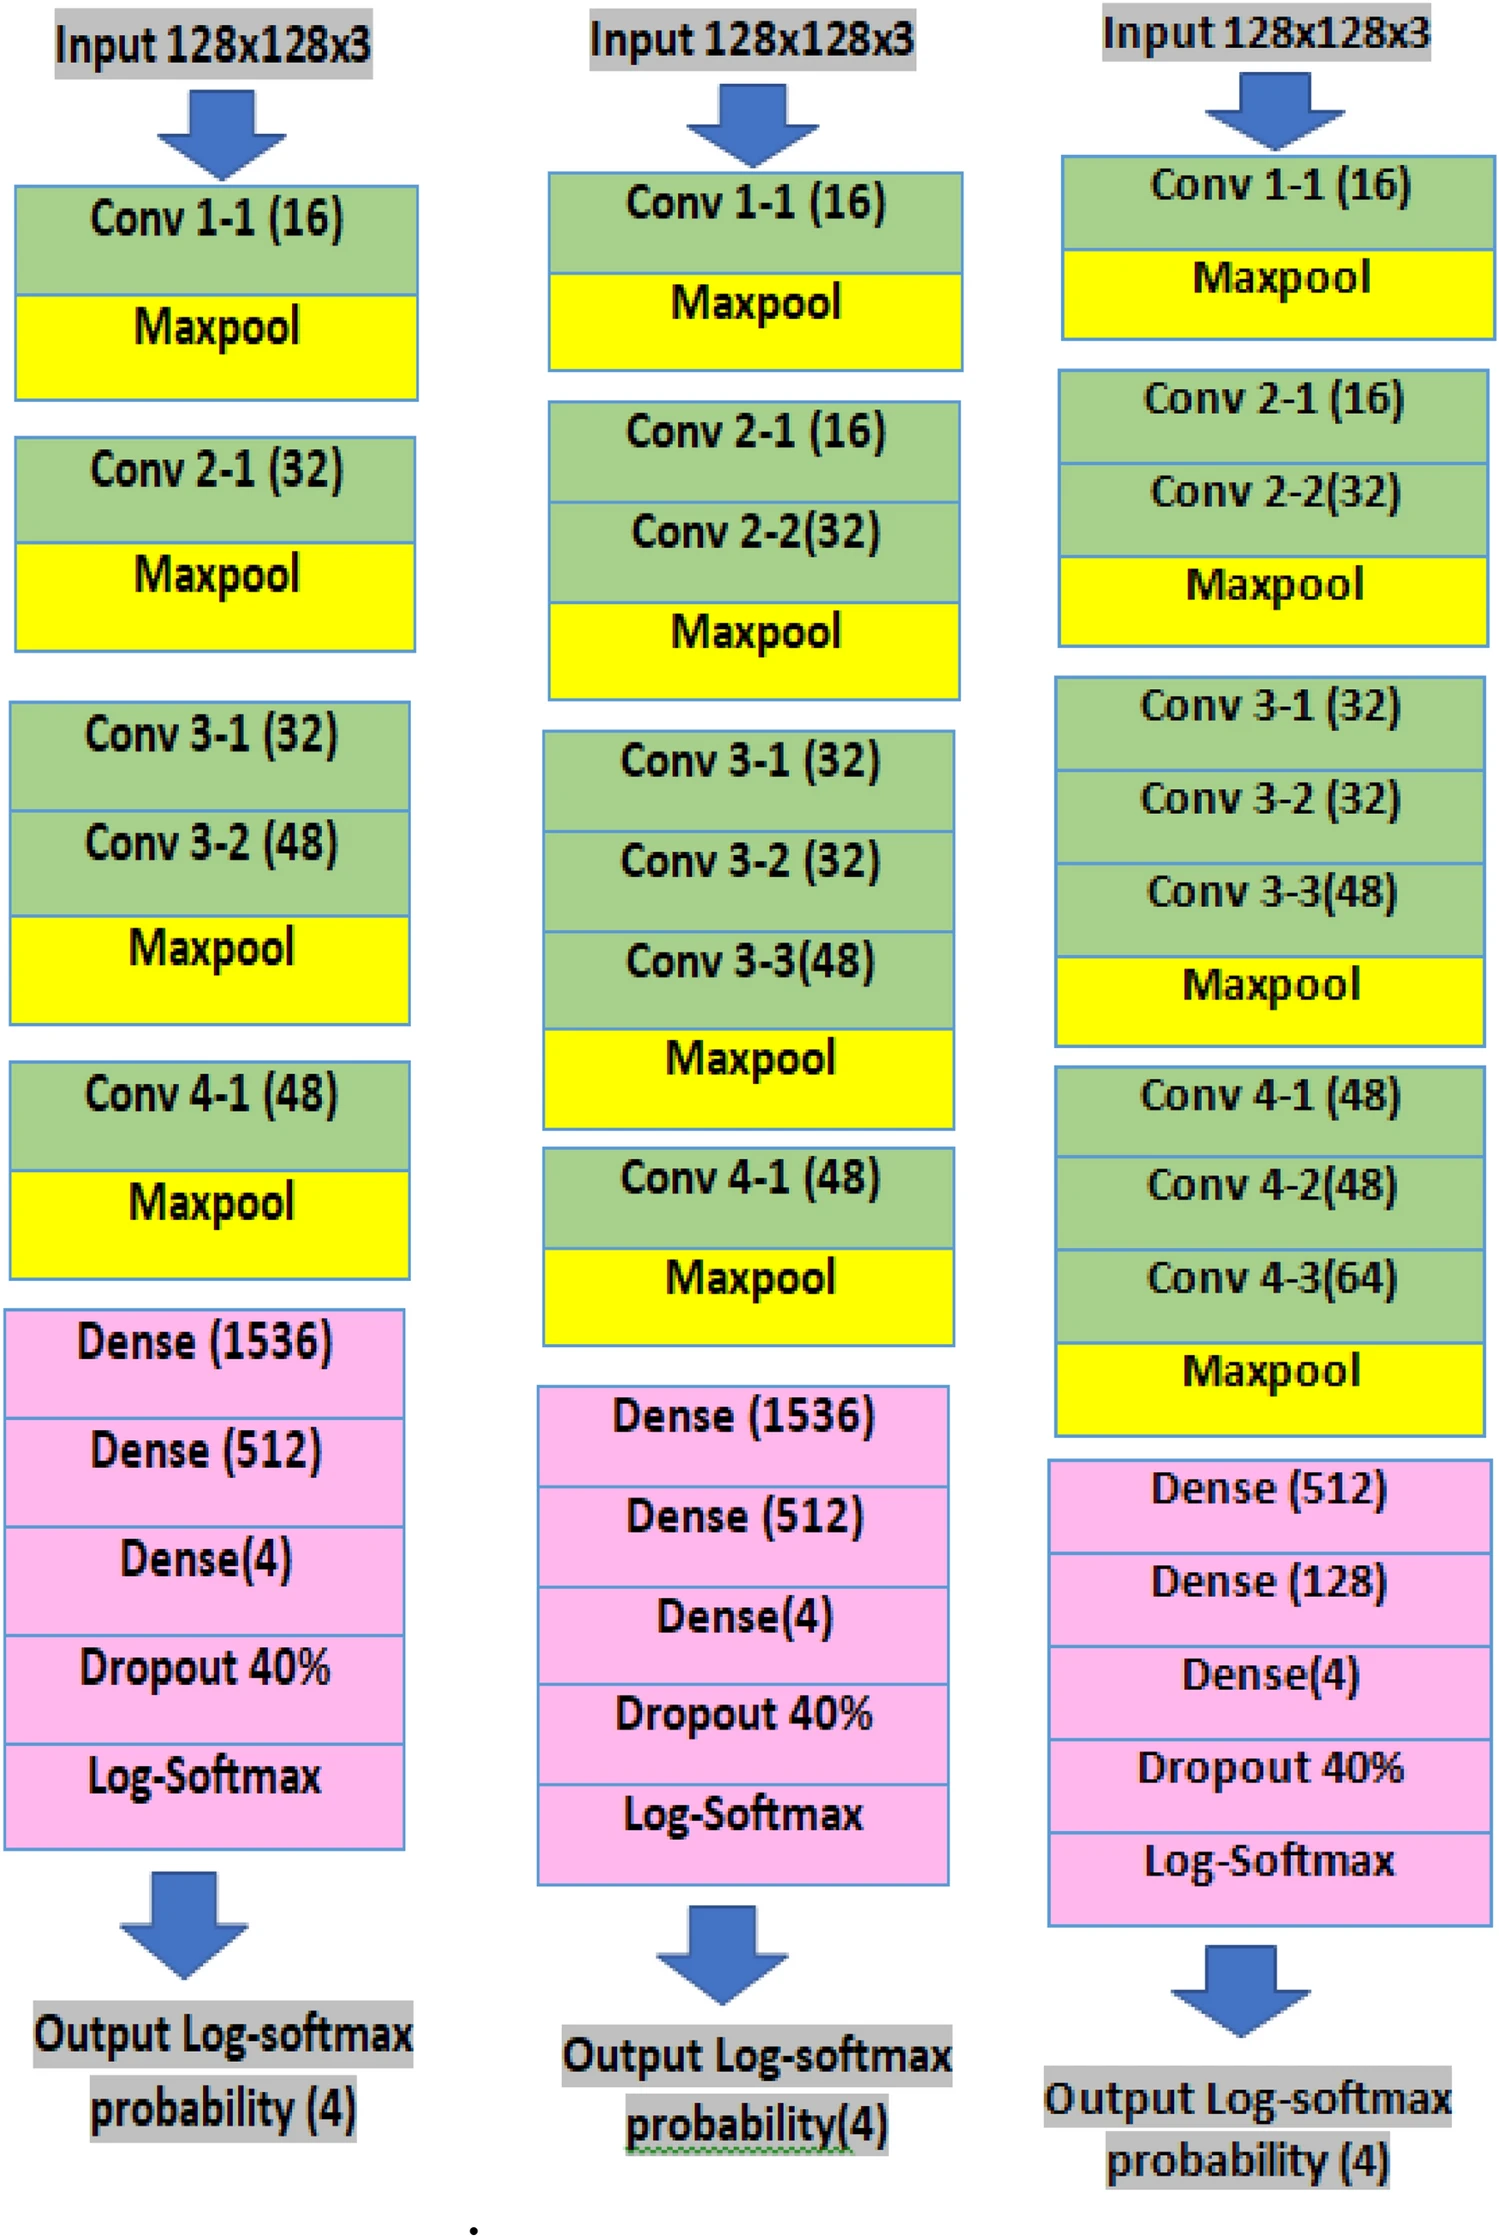

## Architectures used in the article (torch)

In [120]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Definindo a arquitetura da CNN
class CNN5(nn.Module):
    def __init__(self):
        super(CNN5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(1, 1))
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, 1))
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, 1))
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=48, kernel_size=(1, 1))
        self.conv5 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=(1, 1))

        # Calcular o tamanho da saída da última camada convolucional
        self._to_linear = None
        self._initialize_weights()

    def _initialize_weights(self):
        # Cria uma entrada fictícia para calcular o tamanho da saída da camada convolucional
        x = torch.randn(1, 3, 128, 128)  # Um exemplo com batch size 1
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        self._to_linear = x.numel()  # Número total de elementos na saída

        # Definir as camadas totalmente conectadas
        self.fc1 = nn.Linear(self._to_linear, 1536)
        self.fc2 = nn.Linear(1536, 512)
        self.fc3 = nn.Linear(512, 4)
        # TODO: FALTA A CAMADA DE DROPOUT 40%
        # TODO: FALTA A CAMADA DE LOG-SOFTMAX
        # OUTPUT: LOG-SOFTMAX PROBABILITY (4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = x.view(x.size(0), -1)  # Achatar o tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)  # Saída logits

In [121]:
# Hiperparâmetros
learning_rate = 0.001
epochs = 3  # Modifique conforme necessário

# Instanciando o modelo, critério de perda e otimizador
model = CNN5()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# TODO: MODIFICAR PARA USAR O CUDA QUANDO ESTIVER COM A GPU ATIVADA

In [127]:
import time
import torch.nn.functional as F
from tqdm import tqdm  # Importar tqdm para a barra de progresso

# Treinamento
model.train()

for epoch in range(epochs):
    start_time = time.time()  # Início do tempo
    running_loss = 0.0
    # Usando tqdm para acompanhar o progresso
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False):
        optimizer.zero_grad()  # Zerar gradientes
        outputs = model(inputs)  # Forward pass
        loss = criterion(F.log_softmax(outputs, dim=1), labels)  # Calcular a perda
        loss.backward()  # Backward pass
        optimizer.step()  # Atualizar pesos
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)  # Cálculo da perda média
    elapsed_time = time.time() - start_time  # Cálculo do tempo decorrido
    
    # Impressão do resultado ao final da época
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, Time: {elapsed_time:.2f}s')


Epoch [1/3], Loss: 1.1196, Time: 1251.97s


Epoch [2/3], Loss: 0.9121, Time: 1257.88s


Epoch [3/3], Loss: 0.8441, Time: 1270.29s



In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm  # Importar tqdm para a barra de progresso

# Avaliação do modelo no conjunto de teste
model.eval()  # Coloca o modelo em modo de avaliação
all_preds = []
all_labels = []

# Barra de progresso para o loop de inferência no conjunto de teste
with torch.no_grad():  # Desabilitar o cálculo de gradiente para economizar memória
    for inputs, labels in tqdm(test_loader, desc="Test Progress", leave=False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # Obter as previsões
        all_preds.extend(preds.cpu().numpy())  # Armazenar previsões
        all_labels.extend(labels.cpu().numpy())  # Armazenar rótulos verdadeiros

In [ ]:
from sklearn.metrics import confusion_matrix
# Gerar a matriz de confusão
conf_matrix = confusion_matrix(all_labels, all_preds)

# Exibir a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
           xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Calcular acurácia
accuracy = accuracy_score(all_labels, all_preds)
print(f"Acurácia: {accuracy:.4f}")

# Calcular precisão, recall e F1-score (para cada classe e média ponderada)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"Precisão (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-score (weighted): {f1:.4f}")
